Gaussian Naive Bayes Training of Data

In [1]:
#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold as RSK, GridSearchCV
from sklearn.preprocessing import PowerTransformer
import warnings
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
# Reading the dataset
dataset = pd.read_csv("wdbc.data.csv", sep=",").values

# Forming a data frame 
attributes = ["ID","Diagnosis","mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness","mean_compactness","mean_concavity","mean_concave_points","mean_symmetry","mean_fractal_dimension","se_radius","se_texture","se_perimeter","se_area","se_smoothness","se_compactness","se_concavity","se_concave_points","se_symmetry","se_fractal_dimension",
            "worst_radius","worst_texture","worst_perimeter","worst_area","worst_smoothness","worst_compactness","worst_concavity","worst_concave_points","worst_symmetry","worst_fractal_dimension"]
data = pd.DataFrame(data=dataset,columns=attributes)
data.set_index("ID", inplace=True)

# Displaying the diagnosis(M = malignant, B = benign) and the 30 real-valued attributes
display(data.head())
# Label-1 indicates malignant and Label-0 indicates benign 
data["Diagnosis"] = data["Diagnosis"].replace("M",1)
data["Diagnosis"] = data["Diagnosis"].replace("B",0)
data = data.apply(pd.to_numeric, errors="ignore")

# X contains only the first 10 features i.e only the mean values of the attributes not their standard error or maximum values

# Mean
X1 = dataset[:,2:12]
X1 = X1.astype("float64")
X1 = np.concatenate([np.ones((X1.shape[0],1)),X1],axis=1)

# Standard error
X2 = dataset[:,12:22]
X2 = X2.astype("float64")
X2 = np.concatenate([np.ones((X2.shape[0],1)),X2],axis=1)

# Maximum
X3 = dataset[:,22:32]
X3 = X3.astype("float64")
X3 = np.concatenate([np.ones((X3.shape[0],1)),X3],axis=1)

# Mean and Standard error
X4 = dataset[:,2:22]
X4 = X4.astype("float64")
X4 = np.concatenate([np.ones((X4.shape[0],1)),X4],axis=1)

# Standard error and Maximum
X5 = dataset[:,12:]
X5 = X5.astype("float64")
X5 = np.concatenate([np.ones((X5.shape[0],1)),X5],axis=1)

# Mean and Maximum
X6 = np.concatenate([X1,X3],axis=1)
X6 = X6.astype("float64")
X6 = np.concatenate([np.ones((X6.shape[0],1)),X6],axis=1)

# Mean, Standard error and Maximum
X7 = dataset[:,2:]
X7 = X7.astype("float64")
X7 = np.concatenate([np.ones((X7.shape[0],1)),X7],axis=1)

labels = data["Diagnosis"].values.reshape(-1,1)
data.drop("Diagnosis", axis = 1, inplace = True)
final_data1 = np.concatenate([X1,labels],axis=1)
final_data2 = np.concatenate([X2,labels],axis=1)
final_data3 = np.concatenate([X3,labels],axis=1)
final_data4 = np.concatenate([X4,labels],axis=1)
final_data5 = np.concatenate([X5,labels],axis=1)
final_data6 = np.concatenate([X6,labels],axis=1)
final_data7 = np.concatenate([X7,labels],axis=1)

,Diagnosis,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,...,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension
ID,,,,,,,,,,,,,,,,,,,,,
842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
84300903,M,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,0.2069,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,0.2597,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
84358402,M,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,0.1809,...,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
843786,M,12.45,15.7,82.57,477.1,0.1278,0.17,0.1578,0.08089,0.2087,...,15.47,23.75,103.4,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.1244


In [3]:
def skNBSolver(final_data):
    report = np.zeros([4, 6]) #row, column
    m,n = final_data.shape
    for i in range(5):
        np.random.seed(0)
        np.random.shuffle(final_data)
        x_train = final_data[0:int(0.8*m),0:n-1]
        y_train = final_data[0:int(0.8*m),n-1]
        x_test  = final_data[int(0.8*m):,0:n-1]
        y_test  = final_data[int(0.8*m):,n-1]
        
        cv_method = RSK(n_splits = 5, n_repeats = 3, random_state = 999)
        params_NB = {'var_smoothing': np.logspace(0,-9, num = 100)}
        
        GB = GaussianNB()
        gs_NB = GridSearchCV(estimator = GB, param_grid = params_NB, cv = cv_method,scoring = 'accuracy')
        gs_NB.fit(x_train,y_train)
        gs_NB.fit(x_test,y_test)
        sk_train_acc = gs_NB.score(x_train,y_train) * 100
        sk_test_acc = gs_NB.score(x_test,y_test) * 100
        predictions = gs_NB.predict(x_test)
    
        report[0,i] = (classification_report(y_test,predictions, output_dict=True).get('accuracy'))
        report[1,i] = (classification_report(y_test,predictions, output_dict=True).get('macro avg').get('precision'))
        report[2,i] =(classification_report(y_test,predictions, output_dict=True).get('macro avg').get('recall'))
        report[3,i] =(classification_report(y_test,predictions, output_dict=True).get('macro avg').get('f1-score'))
        print(classification_report(y_test,predictions))

        cm = metrics.confusion_matrix(y_test, predictions)
        print("Confusion matrix:\n",cm)
    
    #reporting the maximum values for each row
    for i in range(4):
        report[i,5]= max(report[i,0:5])
    
    
    columns = ["Validation1","Validation2","Validation3","Validation4","Validation5","Maximum Value"]
    index = ["Accuracy", "Precision", "Recall", "F1 Score"]
    df1 = pd.DataFrame(data = report, columns = columns, index = index)
    display(df1)
    
    ##############
    return sk_train_acc, sk_test_acc

In [4]:
#Mean
sk_train_acc_1, sk_test_acc_1 = skNBSolver(final_data1)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_1))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95        75
         1.0       0.97      0.82      0.89        39

    accuracy                           0.93       114
   macro avg       0.94      0.90      0.92       114
weighted avg       0.93      0.93      0.93       114

Confusion matrix:
 [[74  1]
 [ 7 32]]
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92        69
         1.0       0.95      0.78      0.85        45

    accuracy                           0.89       114
   macro avg       0.91      0.87      0.89       114
weighted avg       0.90      0.89      0.89       114

Confusion matrix:
 [[67  2]
 [10 35]]
              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94        69
         1.0       0.97      0.82      0.89        45

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.929825,0.894737,0.921053,0.894737,0.894737,0.929825
Precision,0.941639,0.908038,0.934211,0.892224,0.901689,0.941639
Recall,0.903590,0.874396,0.903865,0.870769,0.880115,0.903865
F1 Score,0.918803,0.885733,0.914749,0.879958,0.887979,0.918803



Test accuracy using sklearn: 89.47%



In [5]:
#SE
sk_train_acc_2, sk_test_acc_2 = skNBSolver(final_data2)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_2))

              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        75
         1.0       0.94      0.74      0.83        39

    accuracy                           0.89       114
   macro avg       0.91      0.86      0.88       114
weighted avg       0.90      0.89      0.89       114

Confusion matrix:
 [[73  2]
 [10 29]]
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91        69
         1.0       0.97      0.73      0.84        45

    accuracy                           0.89       114
   macro avg       0.91      0.86      0.87       114
weighted avg       0.90      0.89      0.88       114

Confusion matrix:
 [[68  1]
 [12 33]]
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87        69
         1.0       0.88      0.64      0.74        45

    accuracy                           0.82       114
   macro avg       0.84      0.79      0.81       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.894737,0.885965,0.824561,0.868421,0.842105,0.894737
Precision,0.907501,0.910294,0.840629,0.916667,0.862132,0.916667
Recall,0.858462,0.859420,0.793237,0.807692,0.814898,0.859420
F1 Score,0.876311,0.874097,0.805128,0.835498,0.826689,0.876311



Test accuracy using sklearn: 84.21%



In [6]:
#Max
sk_train_acc_3, sk_test_acc_3 = skNBSolver(final_data3)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_3))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        75
         1.0       0.97      0.97      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Confusion matrix:
 [[74  1]
 [ 1 38]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95        69
         1.0       0.97      0.87      0.92        45

    accuracy                           0.94       114
   macro avg       0.95      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

Confusion matrix:
 [[68  1]
 [ 6 39]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96        69
         1.0       0.95      0.93      0.94        45

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.982456,0.938596,0.956140,0.956140,0.947368,0.982456
Precision,0.980513,0.946959,0.955844,0.948986,0.948701,0.980513
Recall,0.980513,0.926087,0.952174,0.954359,0.941816,0.980513
F1 Score,0.980513,0.934348,0.953925,0.951576,0.944928,0.980513



Test accuracy using sklearn: 94.74%



In [7]:
#Mean & SE
sk_train_acc_4, sk_test_acc_4 = skNBSolver(final_data4)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_4))

              precision    recall  f1-score   support

         0.0       0.89      0.99      0.94        75
         1.0       0.97      0.77      0.86        39

    accuracy                           0.91       114
   macro avg       0.93      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114

Confusion matrix:
 [[74  1]
 [ 9 30]]
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94        69
         1.0       0.97      0.84      0.90        45

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114

Confusion matrix:
 [[68  1]
 [ 7 38]]
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.92        69
         1.0       0.93      0.82      0.87        45

    accuracy                           0.90       114
   macro avg       0.91      0.89      0.90       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.912281,0.929825,0.903509,0.885965,0.885965,0.929825
Precision,0.929654,0.940513,0.908446,0.912375,0.901544,0.940513
Recall,0.877949,0.914976,0.889372,0.839487,0.865729,0.914976
F1 Score,0.896926,0.924603,0.896833,0.862612,0.876859,0.924603



Test accuracy using sklearn: 88.60%



In [8]:
#SE and Max
sk_train_acc_5, sk_test_acc_5 = skNBSolver(final_data5)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_5))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97        75
         1.0       1.00      0.90      0.95        39

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Confusion matrix:
 [[75  0]
 [ 4 35]]
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96        69
         1.0       0.98      0.89      0.93        45

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114

Confusion matrix:
 [[68  1]
 [ 5 40]]
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94        69
         1.0       0.95      0.87      0.91        45

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.964912,0.947368,0.929825,0.921053,0.929825,0.964912
Precision,0.974684,0.953558,0.934514,0.926838,0.934524,0.974684
Recall,0.948718,0.937198,0.918841,0.896923,0.920077,0.948718
F1 Score,0.959986,0.943990,0.925319,0.909324,0.925974,0.959986



Test accuracy using sklearn: 92.98%



In [9]:
#Mean and Max
sk_train_acc_6, sk_test_acc_6 = skNBSolver(final_data6)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_6))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97        75
         1.0       0.93      0.95      0.94        39

    accuracy                           0.96       114
   macro avg       0.95      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion matrix:
 [[72  3]
 [ 2 37]]
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95        69
         1.0       0.93      0.91      0.92        45

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114

Confusion matrix:
 [[66  3]
 [ 4 41]]
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95        69
         1.0       0.95      0.89      0.92        45

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.956140,0.938596,0.938596,0.956140,0.921053,0.956140
Precision,0.948986,0.937338,0.941468,0.948986,0.922863,0.948986
Recall,0.954359,0.933816,0.929952,0.954359,0.912724,0.954359
F1 Score,0.951576,0.935494,0.934947,0.951576,0.917064,0.951576



Test accuracy using sklearn: 92.11%



In [10]:
#Mean, SE and Max
sk_train_acc_7, sk_test_acc_7 = skNBSolver(final_data7)
print("\nTest accuracy using sklearn: {:.2f}%\n".format(sk_test_acc_7))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97        75
         1.0       0.97      0.90      0.93        39

    accuracy                           0.96       114
   macro avg       0.96      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114

Confusion matrix:
 [[74  1]
 [ 4 35]]
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94        69
         1.0       0.97      0.84      0.90        45

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114

Confusion matrix:
 [[68  1]
 [ 7 38]]
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94        69
         1.0       0.97      0.84      0.90        45

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       11

,Validation1,Validation2,Validation3,Validation4,Validation5,Maximum Value
Accuracy,0.956140,0.929825,0.929825,0.912281,0.903509,0.956140
Precision,0.960470,0.940513,0.940513,0.920314,0.914359,0.960470
Recall,0.942051,0.914976,0.914976,0.884103,0.887468,0.942051
F1 Score,0.950327,0.924603,0.924603,0.898504,0.896833,0.950327



Test accuracy using sklearn: 90.35%



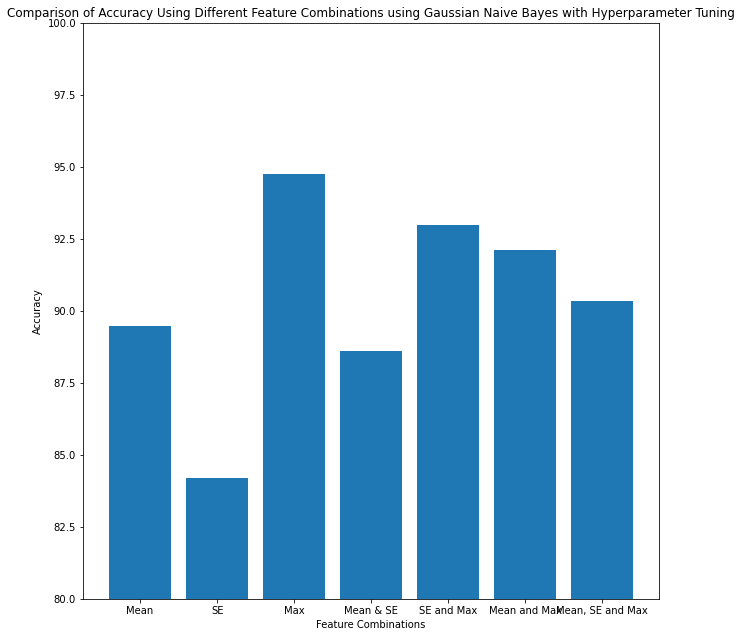

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_axes([0,0,1,1])
feature_comb = ['Mean', 'SE', 'Max', 'Mean & SE', 'SE and Max', 'Mean and Max', 'Mean, SE and Max']
accuracy = [sk_test_acc_1, sk_test_acc_2, sk_test_acc_3, sk_test_acc_4, sk_test_acc_5, sk_test_acc_6, sk_test_acc_7]
ax.bar(feature_comb,accuracy)
ax.set_xlabel('Feature Combinations')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Accuracy Using Different Feature Combinations using Gaussian Naive Bayes with Hyperparameter Tuning')
plt.ylim([80, 100])
plt.tight_layout()
plt.show()

# Selecting 2 parameters

In [21]:
# Extracting the columns representing the maximum values of the features
X = dataset[:,22:32]
X = X.astype("float64")
min_val = np.min(X,axis=0)
max_val = np.max(X,axis=0)
X = np.divide((X-min_val),(max_val-min_val))
final_data = np.concatenate([X,labels],axis=1)
m,n = X.shape

for k in range(5):
    max_f1 = 0
    for i in range(n):
        for j in range(i+1,n):
            x = np.concatenate((X[:,i].reshape(-1,1),X[:,j].reshape(-1,1)),axis=1)
            final_data = np.concatenate([x,labels],axis=1)
            np.random.shuffle(final_data)
            x_train = final_data[0:int(0.8*m),0:2]
            y_train = final_data[0:int(0.8*m),2]
            x_test  = final_data[int(0.8*m):,0:2]
            y_test  = final_data[int(0.8*m):,2]
            
            cv_method = RSK(n_splits = 5, n_repeats = 3, random_state = 999)
            params_NB = {'var_smoothing': np.logspace(0,-9, num = 100)}
        
#             GB = GaussianNB()
#             gs_NB = GridSearchCV(estimator = GB, param_grid = params_NB, cv = cv_method,scoring = 'accuracy')
            gs_NB.fit(x_train,y_train)
            gs_NB.fit(x_test,y_test)
            predictions = gs_NB.predict(x_test)
            
            p = classification_report(y_test,predictions,output_dict = True).get('macro avg').get('precision')
            r = classification_report(y_test,predictions,output_dict = True).get('macro avg').get('recall')
            
            f1 = (2*r*p)/(r+p)
            if f1>max_f1:
                max_f1 = f1
                index1 = i
                index2 = j
    print("F1 = {}\n".format(max_f1))
    print("Feature Combination:\n{}\n{}\n".format(attributes[index1],attributes[index2]))
    print("Indices\n{} and {}\n".format(index1,index2))
            

F1 = 0.9824182603331276

Feature Combination:
ID
mean_perimeter

Indices
0 and 4

F1 = 0.9910016575893914

Feature Combination:
mean_texture
mean_compactness

Indices
3 and 7

F1 = 0.9811070599933709

Feature Combination:
mean_radius
mean_concave_points

Indices
2 and 9

F1 = 0.9633169206752186

Feature Combination:
mean_radius
mean_perimeter

Indices
2 and 4

F1 = 0.9710586443259711

Feature Combination:
mean_radius
mean_concavity

Indices
2 and 8



# Selecting 4 parameters

In [19]:
for t in range(5):
    max_f1 = 0
    for i in range(n):
        for j in range(i+1,n):
            for k in range(j+1,n):
                for l in range(k+1,n):
                            x = np.concatenate((X[:,i].reshape(-1,1),X[:,j].reshape(-1,1),X[:,k].reshape(-1,1),X[:,l].reshape(-1,1)),axis=1)
                            final_data = np.concatenate([x,labels],axis=1)
                            np.random.shuffle(final_data)
                            x_train = final_data[0:int(0.8*m),0:4]
                            y_train = final_data[0:int(0.8*m),4]
                            x_test  = final_data[int(0.8*m):,0:4]
                            y_test  = final_data[int(0.8*m):,4]
                            
                            cv_method = RSK(n_splits = 5, n_repeats = 3, random_state = 999)
                            params_NB = {'var_smoothing': np.logspace(0,-9, num = 100)}
        
                            GB = GaussianNB()
                            gs_NB = GridSearchCV(estimator = GB, param_grid = params_NB, cv = cv_method,scoring = 'accuracy')
                            gs_NB.fit(x_train,y_train)
                            gs_NB.fit(x_test,y_test)
                            predictions = gs_NB.predict(x_test)
                            
                            p = classification_report(y_test,predictions,output_dict = True).get('macro avg').get('precision')
                            r = classification_report(y_test,predictions,output_dict = True).get('macro avg').get('recall')
                            f1 = (2*r*p)/(r+p)
                            if f1>max_f1:
                                max_f1 = f1
                                index1 = i
                                index2 = j
                                index3 = k
                                index4 = l
    print("F1 = {}\n".format(max_f1))
    print("Feature Combination:\n{}\n{}\n{}\n{}\n".format(attributes[index1],attributes[index2],attributes[index3],attributes[index4]))
    print("Indices\n{}, {}, {}, {}\n".format(index1,index2,index3,index4))

F1 = 0.9904080774084981

Feature Combination:
ID
mean_radius
mean_texture
mean_compactness

Indices
0, 2, 3, 7

F1 = 0.9826272477903079

Feature Combination:
mean_radius
mean_texture
mean_smoothness
mean_compactness

Indices
2, 3, 6, 7

F1 = 1.0

Feature Combination:
mean_radius
mean_texture
mean_perimeter
mean_compactness

Indices
2, 3, 4, 7

F1 = 1.0

Feature Combination:
ID
Diagnosis
mean_texture
mean_compactness

Indices
0, 1, 3, 7

F1 = 1.0

Feature Combination:
ID
Diagnosis
mean_perimeter
mean_compactness

Indices
0, 1, 4, 7



In [ ]:
# The F1 score of the k best features selected taking into consideration all possible permutations and combinations.
# The bar graph is made for k=2,4,6,8
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
features = [2,4]
F1 = [0.9646,1.0]
ax.bar(features,F1)
ax.set_xlabel('No. of Features')
ax.set_ylabel('F1 Score')
ax.set_title('Comparison of F1 score selecting k out on n features using Gaussian Naive Bayes')
ax.set_ylim([0.9,1])
plt.show()